Fitting 5 folds for each of 150 candidates, totalling 750 fits


C:\Users\anude\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'C': 10, 'class_weight': {0: 1, 1: 2}, 'l1_ratio': 0.1, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Cross-Validation F1-Score (High Demand): 0.66
Test Accuracy: 0.88
Test ROC AUC: 0.90

Test Classification Report:
              precision    recall  f1-score   support

  Low Demand       0.95      0.90      0.93       262
 High Demand       0.64      0.78      0.70        58

    accuracy                           0.88       320
   macro avg       0.80      0.84      0.81       320
weighted avg       0.89      0.88      0.89       320



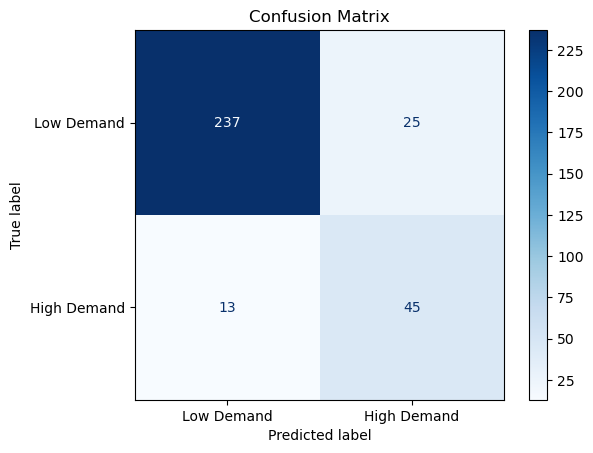

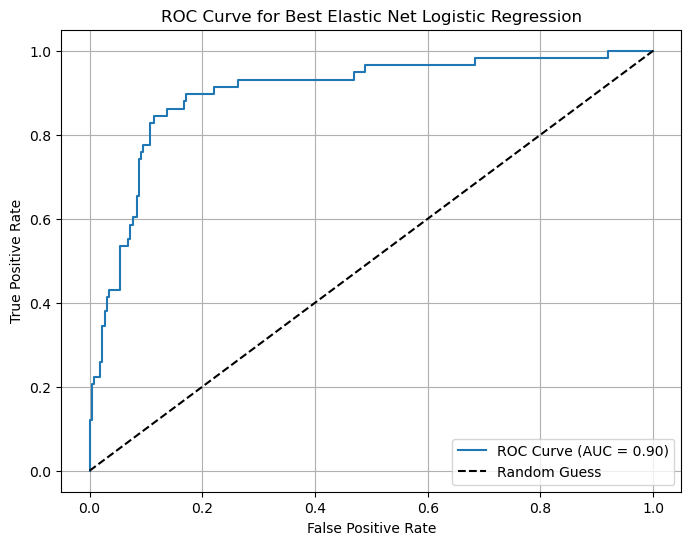

Precision-Recall AUC: 0.70


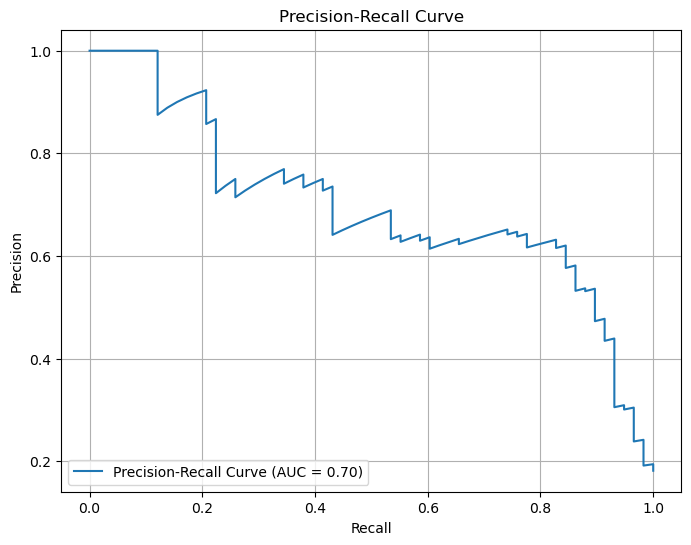

In [1]:
import pandas as pd
df = pd.read_csv('training.csv')
df['increase_stock'] = df['increase_stock'].map({'low_bike_demand': 0, 'high_bike_demand': 1})
df.head()

import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer
)
import matplotlib.pyplot as plt

output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Split the data into training and testing sets (80%-20%)
X = df.drop(columns=['increase_stock'])
y = df['increase_stock']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32, stratify=y
)

# Preprocessing: Cyclic encoding for 'hour_of_day', 'day_of_week', and 'month'
for df_split in [X_train, X_test]:
    df_split.loc[:, 'hour_sin'] = np.sin(2 * np.pi * df_split['hour_of_day'] / 24)
    df_split.loc[:, 'hour_cos'] = np.cos(2 * np.pi * df_split['hour_of_day'] / 24)
    df_split.loc[:, 'day_sin'] = np.sin(2 * np.pi * df_split['day_of_week'] / 7)
    df_split.loc[:, 'day_cos'] = np.cos(2 * np.pi * df_split['day_of_week'] / 7)
    df_split.loc[:, 'month_sin'] = np.sin(2 * np.pi * df_split['month'] / 12)
    df_split.loc[:, 'month_cos'] = np.cos(2 * np.pi * df_split['month'] / 12)

final_features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
    'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'visibility'
]

X_train = X_train[final_features]
X_test = X_test[final_features]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defining logistic regression with elastic net and parameter grid for cross-validation
param_grid = {
    'solver': ['saga'],
    'penalty': ['elasticnet'], 
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [1000, 5000],
    'class_weight': [{0: 1, 1: 1.5}, {0: 1, 1: 2}, {0: 1, 1: 2.5}],
}

model = LogisticRegression()

# Creating a scorer that optimizes for F1-score of the high-demand class
scorer = make_scorer(f1_score, pos_label=1)

# Grid search for F1-score
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring=scorer,
    verbose=2,
    n_jobs=-1,
)
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1-Score (High Demand): {grid_search.best_score_:.2f}")

# Evaluating the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_scaled)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_classification_report = classification_report(
    y_test, y_test_pred, target_names=["Low Demand", "High Demand"]
)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test ROC AUC: {test_roc_auc:.2f}")
print("\nTest Classification Report:")
print(test_classification_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Low Demand", "High Demand"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, "confusion_matrix_LR.png"), dpi=300, bbox_inches="tight")
plt.show()

# ROC Curve for Best Model
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Elastic Net Logistic Regression')
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, "roc_curve_elastic_net_LR.png"), dpi=300, bbox_inches="tight")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = average_precision_score(y_test, y_test_pred_proba)
print(f"Precision-Recall AUC: {pr_auc:.2f}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curve")
plt.grid()
plt.legend(loc='lower left')
plt.savefig(os.path.join(output_dir, "precision_recall_curve_LR.png"), dpi=300, bbox_inches="tight")
plt.show()